<a href="https://colab.research.google.com/github/ibenatar-96/statistical-rethinking-numpyro/blob/main/chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 4 in Statistical Rethinking

In [1]:
!pip install -q numpyro arviz
!git clone https://github.com/fehiepsi/rethinking-numpyro.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 2.6 MB/s eta 0:00:00
Cloning into 'rethinking-numpyro'...
remote: Enumerating objects: 1805, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 1805 (delta 209), reused 273 (delta 142), pack-reused 1397
Receiving objects: 100% (1805/1805), 158.83 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (1228/1228), done.


In [2]:
import os
import warnings

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [3]:
# Code 4.1

pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: >]], dtype=object)

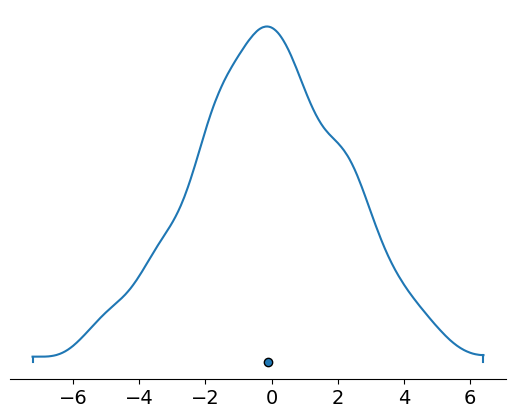

In [4]:
az.plot_density({"": pos}, hdi_prob=1)

In [5]:
# Code 4.2

jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,))) # samples 12 numbers between 1.0 and 1.1, each time multiplying the answer

Array(1.7294353, dtype=float32)

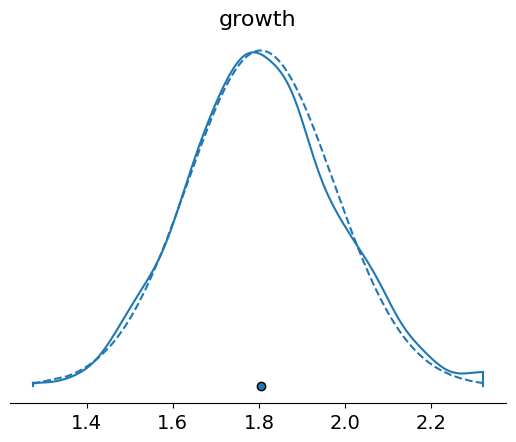

In [6]:
# Code 4.3

# Sample 1000 sets of 12 values from a uniform distribution [0, 0.1], this results in (1000,12) array
uniform_samples = dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12))

# Add 1 to each sampled value
adjusted_samples = 1 + uniform_samples

# Compute the product of the 12 values in each of the 1000 sets (along the last axis), this results in a (1000,1) array
growth = jnp.prod(adjusted_samples, -1)

# Plot the density of the growth values
az.plot_density({"growth": growth}, hdi_prob=1)

# Sort the growth values
x = jnp.sort(growth)

# Plot a normal distribution curve over the sorted growth values
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")

# Show the plot
plt.show()

array([[<Axes: >]], dtype=object)

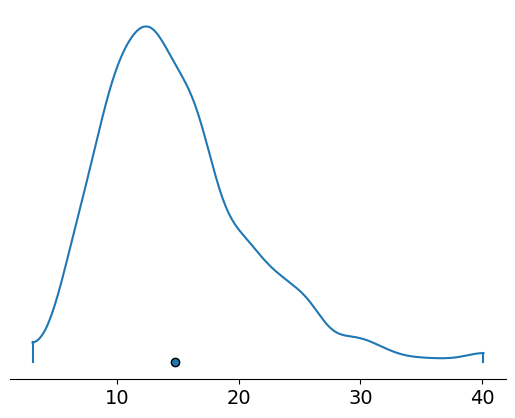

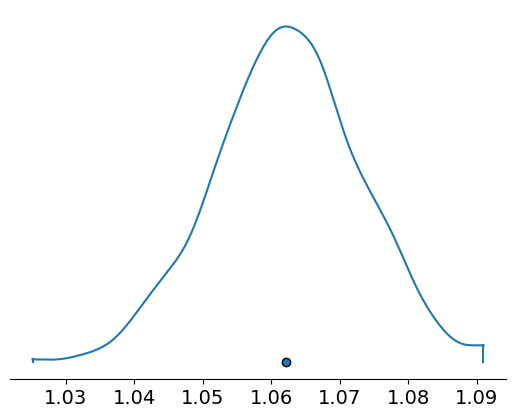

In [7]:
# Code 4.4

big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)

az.plot_density({"": big}, hdi_prob=1)
az.plot_density({"": small}, hdi_prob=1)

In [8]:
# Code 4.7

Howell1 = pd.read_csv("rethinking-numpyro/data/Howell1.csv", sep=";")
d = Howell1

In [9]:
# Code 4.8

d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [10]:
# Code 4.9

print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



In [11]:
# Code 4.10

d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [12]:
# Code 4.11

d2 = d[d.age >= 18]

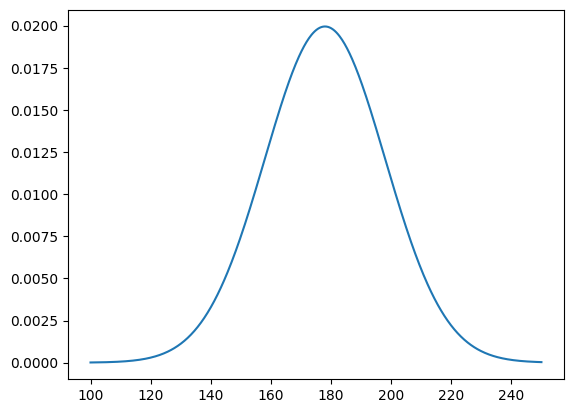

In [13]:
# Code 4.12

x = jnp.linspace(100, 250, d.height.shape[0])
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

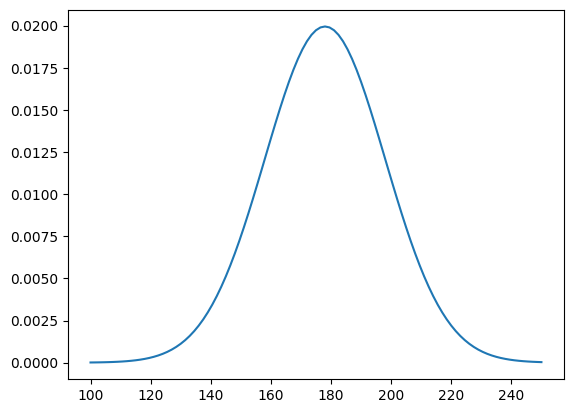

In [14]:
# Code 4.12

# This is the prior for mu (Normal(178,20))
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

<ipython-input-15-18cae32167dd>:5: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))


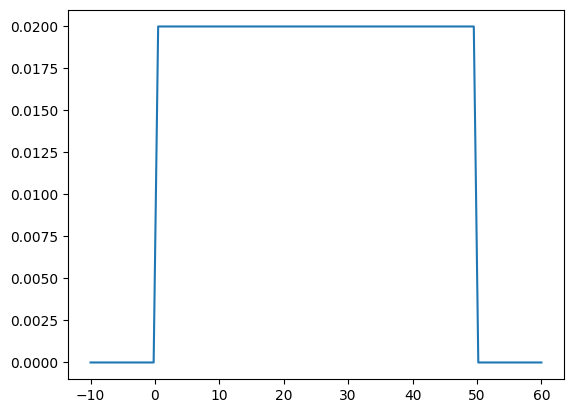

In [15]:
# Code 4.13

# This is the prior for sigma (Uniform(0,50))
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x7dd2c97ba950>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_histogram': File: numba/np/arraymath.py: Line 3912.
    With argument(s): '(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<function linspace at 0x7dd2c9e2e8c0>) found for signature:
    
    >>> linspace(readonly buffer(float32, 0d,

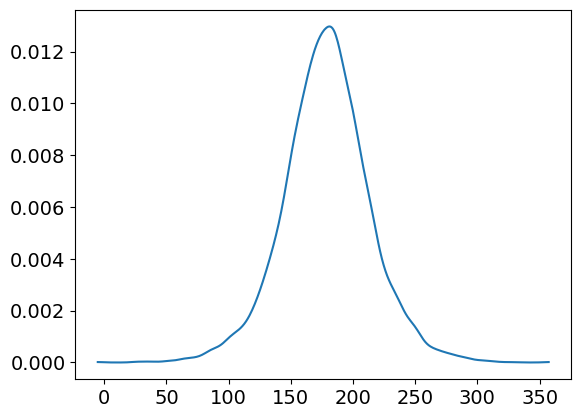

In [16]:
# Code 4.14

# PRIOR PREDICTIVE
sample_mu = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),)) # This returns 10,000 samples from mu
sample_sigma = dist.Uniform(0, 50).sample(random.PRNGKey(1), (int(1e4),)) # This return 10,000 samples from sigma
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2)) # This returns a sample from h, given samples from mu and sigma
az.plot_kde(prior_h)
plt.show()

In [17]:
# Create an array of 100 values linearly spaced between 150 and 160 for mu
mu_list = jnp.linspace(start=150, stop=160, num=100)

# Create an array of 100 values linearly spaced between 7 and 9 for sigma
sigma_list = jnp.linspace(start=7, stop=9, num=100)

# Generate a meshgrid from mu_list and sigma_list, creating two 2D arrays for each combination of mu and sigma
mesh = jnp.meshgrid(mu_list, sigma_list)

# Flatten the meshgrid arrays and store them in a dictionary with keys 'mu' and 'sigma'
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
print(post)

# Calculate the log-likelihood (LL) for each combination of mu and sigma using the data from d2.height.values
# vmap applies the lambda function element-wise to each pair of mu and sigma
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
print(post)
# Calculate the log probability of each mu under a normal distribution with mean 178 and standard deviation 20
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])

# Calculate the log probability of each sigma under a uniform distribution between 0 and 50
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])

# Combine the log-likelihood with the log probabilities of mu and sigma to get the posterior log probability
post["prob"] = post["LL"] + logprob_mu + logprob_sigma

# Convert the log probabilities to actual probabilities by exponentiating and normalizing
# Subtract the maximum log probability for numerical stability before exponentiating
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

{'mu': Array([150.     , 150.10101, 150.20201, ..., 159.79797, 159.89899,
       160.     ], dtype=float32), 'sigma': Array([7., 7., 7., ..., 9., 9., 9.], dtype=float32)}
{'mu': Array([150.     , 150.10101, 150.20201, ..., 159.79797, 159.89899,
       160.     ], dtype=float32), 'sigma': Array([7., 7., 7., ..., 9., 9., 9.], dtype=float32), 'LL': Array([-1299.0303, -1295.7311, -1292.5056, ..., -1285.541 , -1287.8462,
       -1290.1958], dtype=float32)}


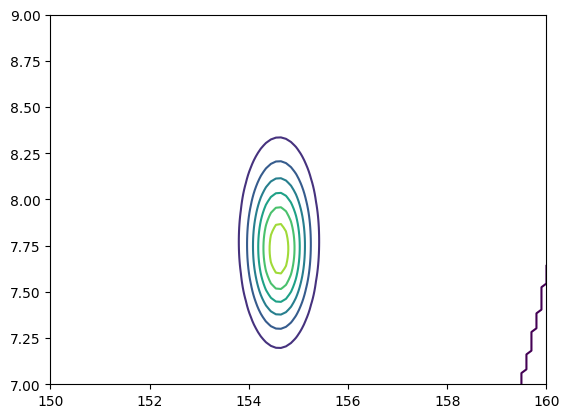

In [18]:
# Create a contour plot with the reshaped mu, sigma, and prob values
plt.contour(
    post["mu"].reshape(100, 100),   # Reshape the flattened mu array back to a 100x100 grid
    post["sigma"].reshape(100, 100), # Reshape the flattened sigma array back to a 100x100 grid
    post["prob"].reshape(100, 100),  # Reshape the flattened prob array back to a 100x100 grid
)
plt.show()

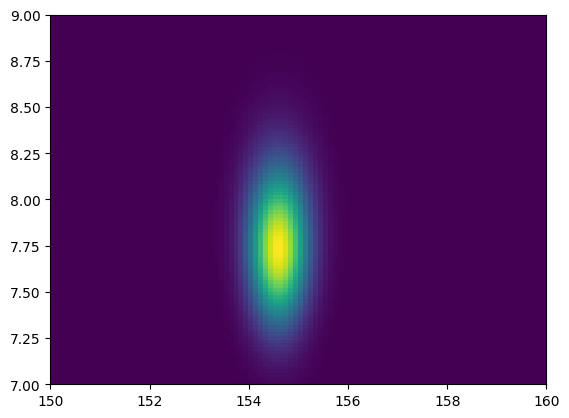

In [19]:
# Code 4.18

plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

In [20]:
# Code 4.19

# Normalize the posterior probabilities so they sum to 1
prob = post["prob"] / jnp.sum(post["prob"])

# Sample 10,000 times from a categorical distribution defined by the normalized probabilities
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))

# Select the mu values corresponding to the sampled indices
sample_mu = post["mu"][sample_rows]

# Select the sigma values corresponding to the sampled indices
sample_sigma = post["sigma"][sample_rows]

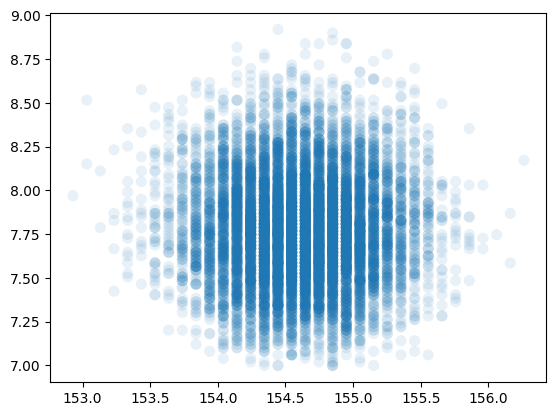

In [21]:
# Code 4.20

plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

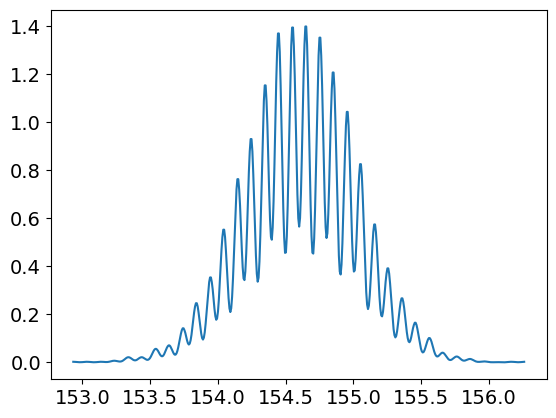

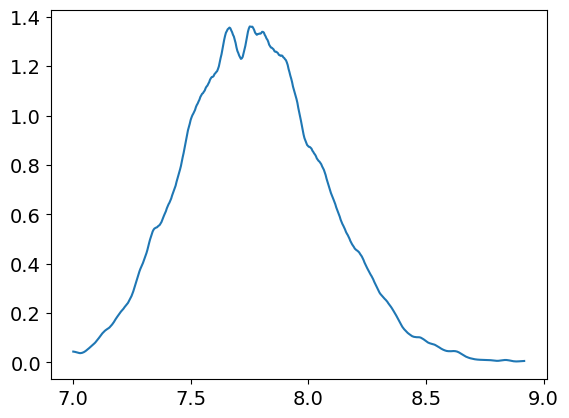

In [22]:
# Code 4.21

# Plot the Kernel Density Estimate (KDE) for the sampled mu values
az.plot_kde(sample_mu)
plt.show()

# Plot the Kernel Density Estimate (KDE) for the sampled sigma values
az.plot_kde(sample_sigma)
plt.show()

In [23]:
# Calculate and print the 89% Highest Posterior Density Interval (HPDI) for the sampled mu values
print(hpdi(sample_mu, 0.89))

# Calculate and print the 89% Highest Posterior Density Interval (HPDI) for the sampled sigma values
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


In [24]:
# Code 4.23

d3 = d2.height.sample(n=20)

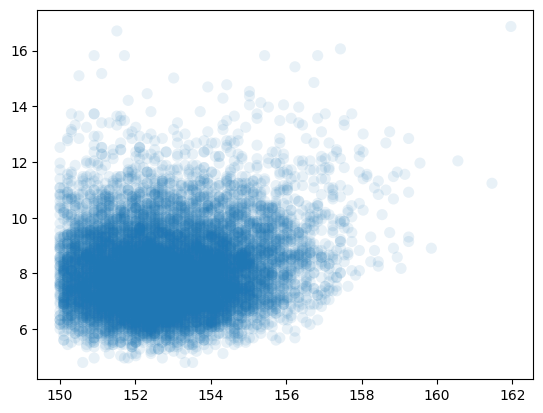

In [25]:
# Code 4.24

# Generate an array of 200 values linearly spaced between 150 and 170 for the parameter mu (mean of the normal distribution)
mu_list = jnp.linspace(start=150, stop=170, num=200)

# Generate an array of 200 values linearly spaced between 4 and 20 for the parameter sigma (standard deviation of the normal distribution)
sigma_list = jnp.linspace(start=4, stop=20, num=200)

# Generate a meshgrid from mu_list and sigma_list, creating two 2D arrays for each combination of mu and sigma
mesh = jnp.meshgrid(mu_list, sigma_list)

# Flatten the meshgrid arrays and store them in a dictionary with keys 'mu' and 'sigma'
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}

# Calculate the log-likelihood (LL) for each combination of mu and sigma using the data from d3.values
# vmap applies the lambda function element-wise to each pair of mu and sigma
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])

# Calculate the log probability of each mu under a normal distribution with mean 178 and standard deviation 20
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])

# Calculate the log probability of each sigma under a uniform distribution between 0 and 50
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])

# Combine the log-likelihood with the log probabilities of mu and sigma to get the posterior log probability
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma

# Convert the log probabilities to actual probabilities by exponentiating and normalizing
# Subtract the maximum log probability for numerical stability before exponentiating
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))

# Normalize the posterior probabilities so they sum to 1
prob = post2["prob"] / jnp.sum(post2["prob"])

# Sample 10,000 times from a categorical distribution defined by the normalized probabilities
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))

# Select the mu values corresponding to the sampled indices
sample2_mu = post2["mu"][sample2_rows]

# Select the sigma values corresponding to the sampled indices
sample2_sigma = post2["sigma"][sample2_rows]

# Create a scatter plot of the sampled mu and sigma values
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")

# Display the scatter plot
plt.show()

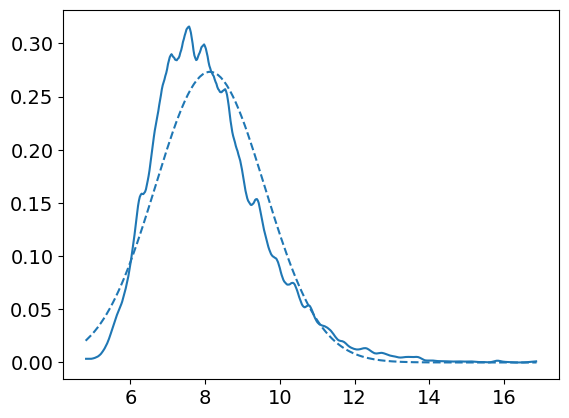

In [26]:
# Plot the Kernel Density Estimate (KDE) for the sampled sigma values
az.plot_kde(sample2_sigma)

# Sort the sampled sigma values for plotting
x = jnp.sort(sample2_sigma)

# Plot the normal distribution fit to the sampled sigma values
# The mean and standard deviation of the fitted normal distribution are calculated from the sorted sampled sigma values
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")

# Display the plot
plt.show()

In [27]:
# Code 4.26

Howell1 = pd.read_csv("rethinking-numpyro/data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

In [28]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

In [29]:
# Create an AutoLaplaceApproximation object for the model defined by flist
m4_1 = AutoLaplaceApproximation(flist)

# Define SVI (Stochastic Variational Inference) with the model m4_1
# Using Adam optimizer with learning rate 1
# Trace_ELBO() calculates the Evidence Lower Bound (ELBO) for the objective
# height=d2.height.values sets the observed data for the model
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values)

# Run SVI to optimize the parameters of m4_1 using random.PRNGKey(0) as the random key, for 2000 iterations
svi_result = svi.run(random.PRNGKey(0), 2000)

# Extract the optimized parameters from the SVI result
p4_1 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 3063.17it/s, init loss: 4000.1155, avg. loss [1901-2000]: 1226.0383]


In [30]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, sample_shape=(1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.05      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



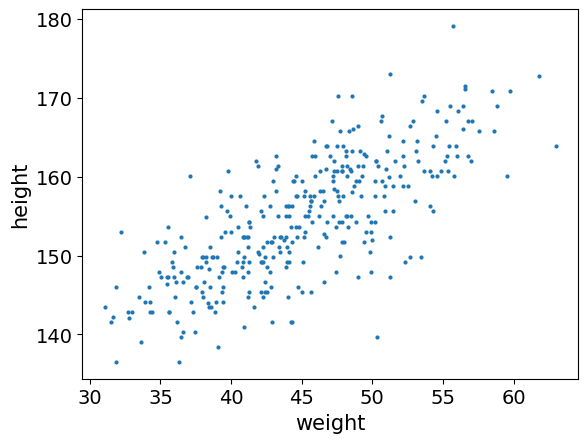

In [31]:
# Plot a pair plot using ArviZ (az) to visualize the relationship between 'weight' and 'height' variables
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
plt.show()

In [32]:
# Set the random seed for reproducibility using numpyro.handlers.seed
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # Number of samples
    # Sample N values from a normal distribution with mean 178 and standard deviation 20, named 'a'
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    # Sample N values from a normal distribution with mean 0 and standard deviation 10, named 'b'
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))

44.99048551988636


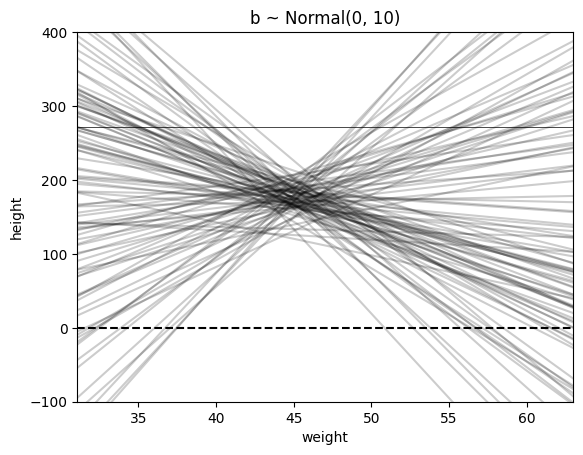

In [33]:
# Create a subplot with specified limits for x-axis (weight) and y-axis (height), and labels
plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400), xlabel="weight", ylabel="height")

# Add a horizontal dashed line at y=0
plt.axhline(y=0, c="k", ls="--")

# Add a horizontal solid line at y=272 with a thinner line width
plt.axhline(y=272, c="k", ls="-", lw=0.5)

# Set the title of the plot
plt.title("b ~ Normal(0, 10)")

# Calculate the mean of weight values from d2
xbar = d2.weight.mean()
print(xbar)

# Create an array of evenly spaced x values for plotting regression lines
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)

# Iterate over each sample and plot the regression line using the formula a[i] + b[i] * (x - xbar)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)

# Display the plot
plt.show()

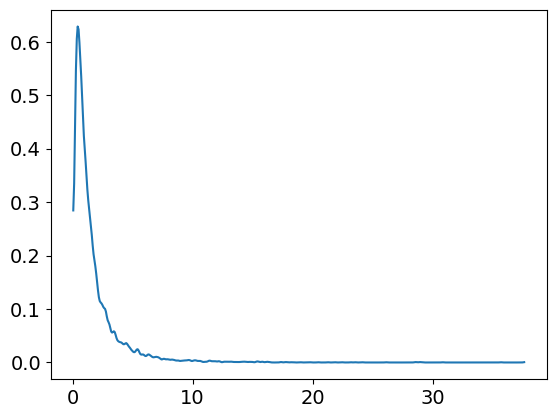

In [34]:
# Sample 10,000 values from a Log-Normal distribution with mean 0 and standard deviation 1
b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))

# Plot the Kernel Density Estimate (KDE) of the sampled values 'b' using ArviZ (az)
az.plot_kde(b)

# Display the plot
plt.show()

In [35]:
# Set the random seed for reproducibility using numpyro.handlers.seed
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # Number of samples
    # Sample N values from a normal distribution with mean 178 and standard deviation 28, named 'a'
    a = numpyro.sample("a", dist.Normal(178, 28).expand([N]))
    # Sample N values from a log-normal distribution with mean 0 and standard deviation 1, named 'b'
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))

In [36]:
# Load data from Howell1.csv and filter for adults (age >= 18)
Howell1 = pd.read_csv("rethinking-numpyro/data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# Define the average weight (x-bar)
xbar = d2.weight.mean()

# Define the model using NumPyro
def model(weight, height):
    # Prior for intercept 'a' with mean 178 and standard deviation 20
    a = numpyro.sample("a", dist.Normal(178, 20))
    # Prior for slope 'b' with mean 0 and standard deviation 1 (log-normal distributed)
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    # Prior for observation noise 'sigma' with uniform distribution between 0 and 50
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    # Deterministic variable 'mu' representing the mean height prediction
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    # Likelihood of observed height data given mu and sigma
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Instantiate AutoLaplaceApproximation for the model
m4_3 = AutoLaplaceApproximation(model)

# Define SVI (Stochastic Variational Inference) with Adam optimizer, Trace_ELBO objective
# Provide weight and height data as observations
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)

# Run SVI to optimize parameters of m4_3 using random.PRNGKey(0) as the random key, for 2000 iterations
svi_result = svi.run(random.PRNGKey(0), 2000)

# Extract optimized parameters from SVI result
p4_3 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 2796.38it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9296]


In [37]:
samples = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.62      0.27    154.63    154.16    155.03    931.50      1.00
         b      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



Reading into the data:
* b :
    * since b is the slope. the value 0.91 means that a person 1 kg heavier is expected to be 0.91 cm taller.
    * 89% of the posterior probability lies between 0.84 and 0.97
    * this DOES NOT mean that the relationship between weight and height are linear, only that if we were assuming that it is linear, then lines with slopes 0.91 are plausible ones.

In [38]:
# Compute the covariance matrix of the stacked samples using JAX numpy (jnp)
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 3)

Array([[ 0.075, -0.   ,  0.001],
       [-0.   ,  0.002, -0.   ],
       [ 0.001, -0.   ,  0.038]], dtype=float32)

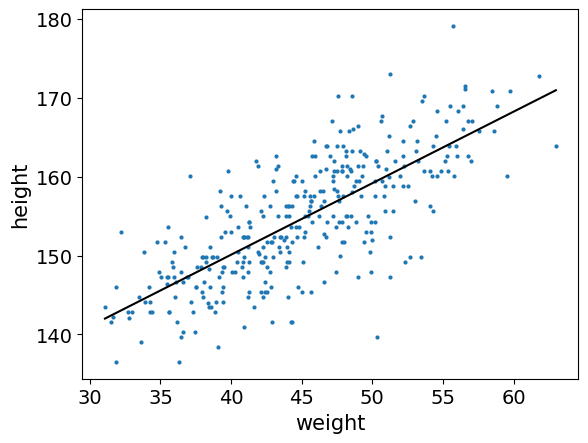

In [39]:
# Plot a pair plot using ArviZ (az) to visualize the relationship between 'weight' and 'height' variables
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))

# Sample posterior from m4_3 using the optimized parameters p4_3, with 1000 samples
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(1000,))

# Compute the mean of 'a' and 'b' from the posterior samples
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])

# Create an array of evenly spaced x values for plotting the regression line
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)

# Plot the mean regression line using the calculated 'a_map' and 'b_map' parameters
plt.plot(x, a_map + b_map * (x - xbar), "k")

# Display the plot
plt.show()

In [40]:
# Sample posterior from m4_3 using the optimized parameters p4_3, with 1000 samples
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(1000,))

# Extract and display the first 5 samples of each latent variable in the posterior
{latent: list(post[latent].reshape(-1)[:5]) for latent in post}

{'a': [Array(154.36615, dtype=float32),
  Array(154.78511, dtype=float32),
  Array(154.73534, dtype=float32),
  Array(154.53842, dtype=float32),
  Array(154.53549, dtype=float32)],
 'b': [Array(0.97464514, dtype=float32),
  Array(0.890005, dtype=float32),
  Array(0.81902224, dtype=float32),
  Array(0.8334105, dtype=float32),
  Array(1.0119181, dtype=float32)],
 'mu': [Array(157.12938, dtype=float32),
  Array(146.0771, dtype=float32),
  Array(141.5733, dtype=float32),
  Array(162.21344, dtype=float32),
  Array(150.74669, dtype=float32)],
 'sigma': [Array(4.9764595, dtype=float32),
  Array(4.94353, dtype=float32),
  Array(5.2826037, dtype=float32),
  Array(4.877722, dtype=float32),
  Array(4.89487, dtype=float32)]}

In [41]:
# Define the number of observations to use
N = 10

# Select the first N observations from d2 for modeling
dN = d2[:N]

# Define the model using NumPyro
def model(weight, height):
    # Prior for intercept 'a' with mean 178 and standard deviation 20
    a = numpyro.sample("a", dist.Normal(178, 20))
    # Prior for slope 'b' with mean 0 and standard deviation 1 (log-normal distributed)
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    # Prior for observation noise 'sigma' with uniform distribution between 0 and 50
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    # Deterministic variable 'mu' representing the mean height prediction
    mu = a + b * (weight - jnp.mean(weight))
    # Likelihood of observed height data given mu and sigma
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Instantiate AutoLaplaceApproximation for the model
mN = AutoLaplaceApproximation(model)

# Define SVI (Stochastic Variational Inference) with Adam optimizer, Trace_ELBO objective
# Provide weight and height data as observations
svi = SVI(
    model,
    mN,
    optim.Adam(1),
    Trace_ELBO(),
    weight=dN.weight.values,
    height=dN.height.values,
)

# Run SVI to optimize parameters of mN using random.PRNGKey(0) as the random key, for 1000 iterations
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract optimized parameters from SVI result
pN = svi_result.params


100%|██████████| 1000/1000 [00:00<00:00, 1248.65it/s, init loss: 1233.4979, avg. loss [951-1000]: 37.0481]


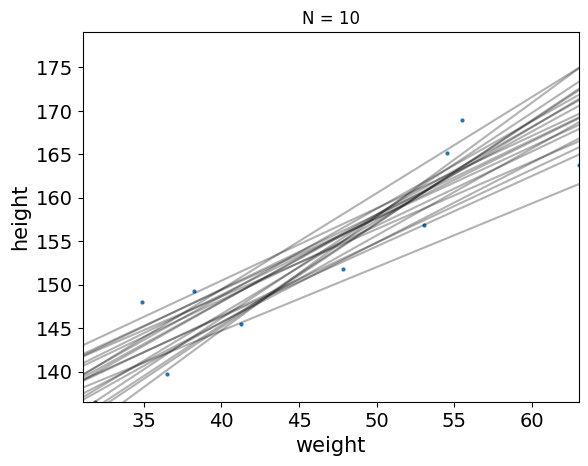

In [42]:
# Extract 20 samples from the posterior using mN and optimized parameters pN
post = mN.sample_posterior(random.PRNGKey(1), pN, sample_shape=(20,))

# Plot a pair plot of 'weight' vs 'height' using ArviZ (az)
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))

# Set the x-axis and y-axis limits to the full range of d2 data
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N = {}".format(N),
)

# Create an array of evenly spaced x values for plotting the regression lines
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)

# Plot 20 regression lines with transparency
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()), "k", alpha=0.3)


In [48]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(1000,))
post.pop("mu")
mu_at_50 = post["a"] + post["b"] * (50 - xbar)

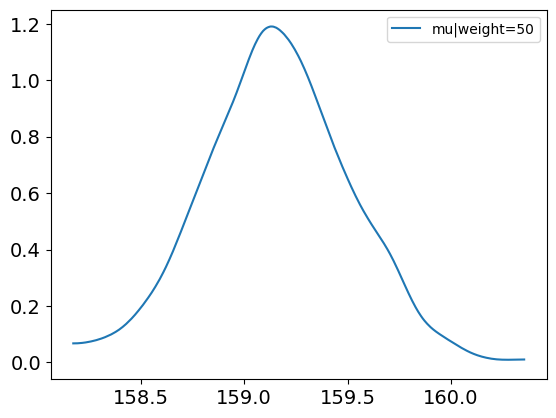

In [47]:
az.plot_kde(mu_at_50, label="mu|weight=50")
plt.show()

In [50]:
# Define the predictive function with the model m4_3 and posterior samples post,
# returning the predictions for the "mu" parameter
mu_predictive = Predictive(m4_3.model, post, return_sites=["mu"])

# Generate a random key for the predictive function and pass in the weight and height values from dataset d2
mu_samples = mu_predictive(random.PRNGKey(2), d2.weight.values, d2.height.values)["mu"]

# Check the shape of the resulting predictions and display the first 5 samples for the first individual
mu_shape = mu_samples.shape
first_five_mu_samples = list(mu_samples[:5, 0])

# Print the shape of mu and the first 5 predicted values for the first individual
print(mu_shape, first_five_mu_samples)

(1000, 352) [Array(157.12938, dtype=float32), Array(157.30838, dtype=float32), Array(157.05736, dtype=float32), Array(156.90125, dtype=float32), Array(157.4044, dtype=float32)]


In [51]:
# Define sequence of weights to compute predictions for
# These values will be on the horizontal axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# Use predictive to compute mu
# For each sample from posterior
# And for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]

# Check the shape of the resulting predictions and display the first 5 samples for the first weight in weight_seq
mu_shape = mu.shape
first_five_mu_samples = list(mu[:5, 0])

# Print the shape of mu and the first 5 predicted values for the first weight in weight_seq
print(mu_shape, first_five_mu_samples)

(1000, 46) [Array(134.88252, dtype=float32), Array(136.99348, dtype=float32), Array(138.36269, dtype=float32), Array(137.87814, dtype=float32), Array(134.30676, dtype=float32)]


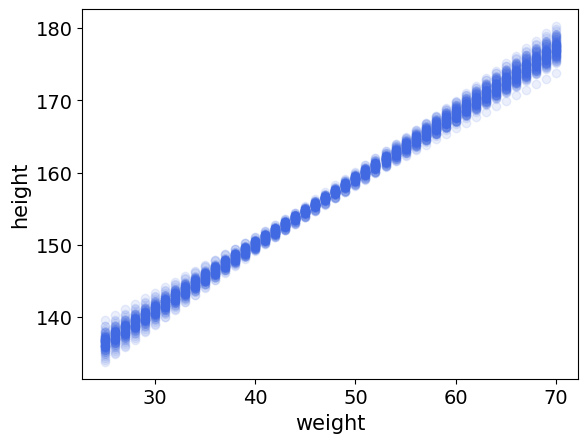

In [52]:
# Use scatter_kwargs={"alpha": 0} to hide raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0}
)

# Loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)

# Display the plot
plt.show()

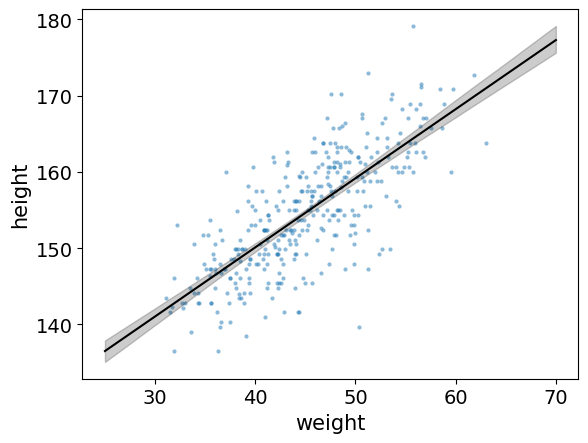

In [54]:
# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

# Plot raw data
# Fading out points to make line and interval more visible
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# Plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# Plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

# Display the plot
plt.show()